In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from glob import glob
import pickle

from PIL import ImageColor
import matplotlib.colors

from utils import NN_FEATURES_DIR, RESULTS_DIR, SUBJECTS, NUM_TEST_STIMULI, FMRI_SURFACE_LEVEL_DIR, STIM_INFO_PATH, COCO_IMAGES_DIR, STIMULI_IDS_PATH, IDS_IMAGES_TEST, IDS_IMAGES_IMAGERY, IMAGERY_SCENES
from analyses.ridge_regression_decoding import NUM_CV_SPLITS, DECODER_OUT_DIR, calc_rsa, calc_rsa_images, calc_rsa_captions, get_fmri_data, pairwise_accuracy, \
ACC_MODALITY_AGNOSTIC, ACC_CAPTIONS, ACC_IMAGES, get_default_features, get_default_vision_features, get_default_lang_features, Normalize, IMAGE, CAPTION, get_distance_matrix, \
ACC_IMAGERY, ACC_IMAGERY_WHOLE_TEST, calc_all_pairwise_accuracy_scores, get_nn_latent_data, get_fmri_data_paths

from notebook_utils import add_avg_subject, create_result_graph, plot_metric_catplot, plot_metric, load_results_data, ACC_MEAN, PALETTE_BLACK_ONLY, METRICS_IMAGERY, get_data_default_feats

In [2]:
# MODELS = ["random-flava", "vit-b-16", "vit-l-16", "resnet-18", "resnet-50", "resnet-152", "dino-base", "dino-large", "dino-giant",
#                "bert-base-uncased", "bert-large-uncased", "llama2-7b", "llama2-13b", "mistral-7b", "mixtral-8x7b", "gpt2-small", "gpt2-medium", "gpt2-large", "gpt2-xl",
#                "visualbert", "lxmert", "bridgetower-large", "vilt", "clip", "imagebind", "flava", "blip2"]
MODELS = ["clip", "imagebind", "flava", "blip2", "gpt2-large", "gpt2-xl", "dino-large", "dino-giant", "lxmert", "bridgetower-large", "vilt", "visualbert"]
all_data = load_results_data(MODELS, metrics=METRICS_IMAGERY, recompute_acc_scores=False)

100%|██████████| 3864/3864 [01:30<00:00, 42.69it/s] 


In [3]:
data_whole_brain = all_data.copy()

data_whole_brain = data_whole_brain[data_whole_brain["mask"] == "whole_brain"]
data_whole_brain = data_whole_brain[data_whole_brain.surface == False]

### Model performance ranking

In [4]:
data_default_feats = get_data_default_feats(data_whole_brain)

dp = data_default_feats.copy()
dp = dp[dp.training_mode == 'modality-agnostic']

dp = dp[dp.metric == ACC_IMAGERY_WHOLE_TEST]
for model in dp.model.unique():
    if len(dp[dp.model == model]) != len(SUBJECTS):
        print(f"unexpected number of datapoints for {model}: {len(dp[dp.model == model])}")
scores = dp.groupby("model").value.mean().sort_values()

print(scores)

model
lxmert               0.614632
visualbert           0.657277
dino-giant           0.705008
clip                 0.734742
dino-large           0.741784
gpt2-xl              0.749218
gpt2-large           0.753521
vilt                 0.757042
blip2                0.769953
flava                 0.77543
bridgetower-large    0.799296
imagebind            0.808294
Name: value, dtype: object


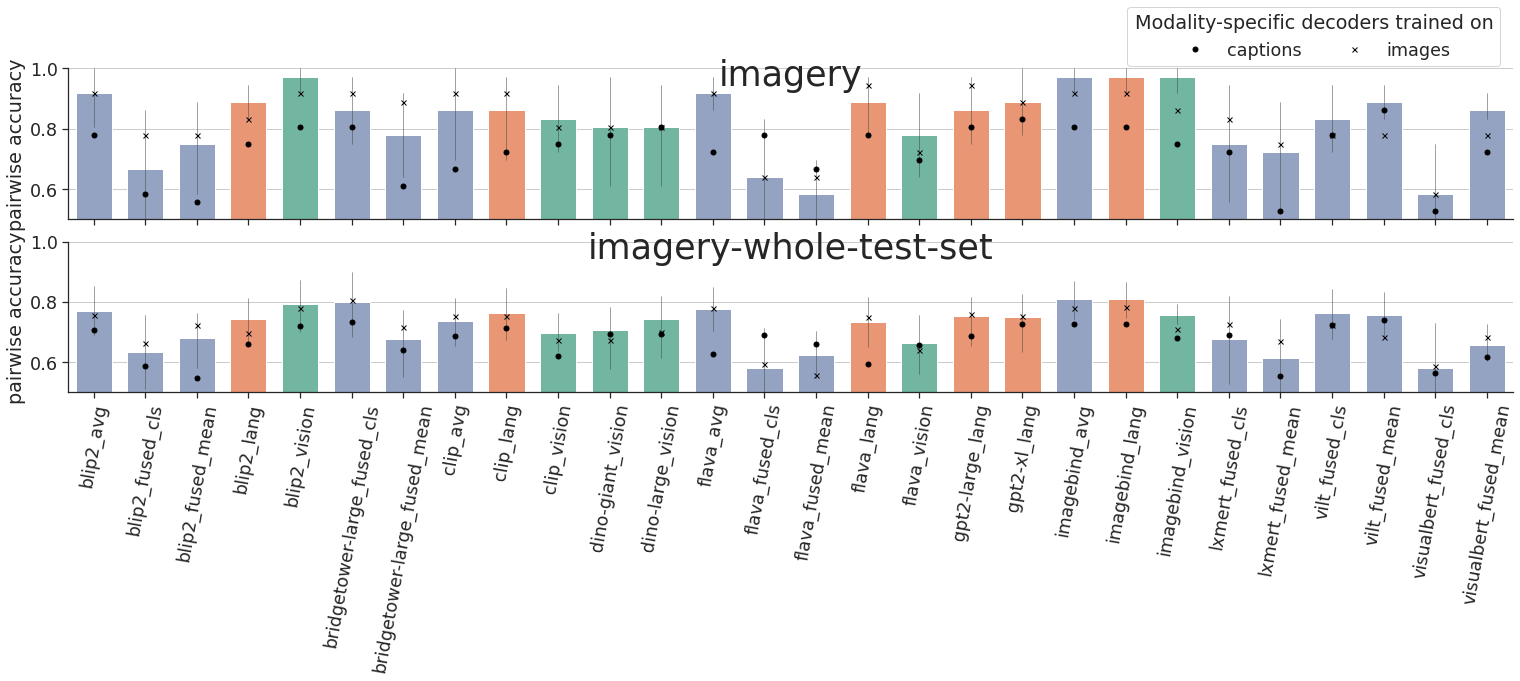

In [5]:
sns.set(font_scale=1.6)
TRAIN_MODE_ORDER = ["images", "captions", "modality-agnostic"]
FEAT_ORDER = ["vision models", "language models", "multimodal models"]
FEATS_MULTIMODAL = ["fused_mean", "fused_cls", "avg", "matched"]

data_to_plot = data_whole_brain.copy()

data_to_plot = data_to_plot[data_to_plot.features != "matched"]

data_to_plot["features"] = data_to_plot.features.replace({"vision": "vision models", "lang": "language models"})
data_to_plot["features"] = data_to_plot.features.replace({f: "multimodal models" for f in FEATS_MULTIMODAL})

model_feat_order = data_to_plot.model_feat.unique()
# print(model_feat_order)

metrics_order = [ACC_IMAGERY, ACC_IMAGERY_WHOLE_TEST]
figure, lgd = create_result_graph(data_to_plot, order=model_feat_order, metrics=metrics_order, row_order=metrics_order, hue_order=FEAT_ORDER, ylim=(0.5, 1), row_title_height=0.85,
                             legend_bbox=(0.06,0.98), legend_2_bbox=(0.99,1.06), height=4.5, legend_title="Modality-agnostic decoders projecting into feature space of", plot_legend=False, verify_num_datapoints=False, shorten_label_texts=False)

# plt.savefig(os.path.join(RESULTS_DIR, f"imagery_features_comparison_pairwise_acc.png"), bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0, dpi=300)

# Imagery decoding with mask

In [6]:
FEAT_ORDER = ["vision", "lang", "vision+lang", "matched"]
FEAT_PALETTE = sns.color_palette('Set2')
PALETTE_BLACK_ONLY = [(0, 0, 0)] * 10


def create_result_graph_cluster_comparisons(data, x_variable="model_feat", order=None, metrics=["pairwise_acc_captions", "pairwise_acc_images"],
                        hue_variable="features", hue_order=FEAT_ORDER, ylim=None,
                        legend_title="Legend", palette=FEAT_PALETTE, dodge=False, noise_ceilings=None,
                        row_variable="metric", row_order=None, col_variable=None, legend_bbox=(0.06, 0.97),
                        legend_2_bbox=(0.99, 0.97), height=4.5, row_title_height=0.85, aspect=4,
                        verify_num_datapoints=True):

    for x_variable_value in order:
        length = len(data[(data[x_variable] == x_variable_value) & (data.metric == metrics[0])])
        # print(data[(data[x_variable] == x_variable_value) & (data.metric == metrics[0]) & (data.subject == SUBJECTS[0])])
        expected_num_datapoints = len(SUBJECTS)
        if hue_variable != "features":
            expected_num_datapoints *= len(data[hue_variable].unique())
        if (length > 0) and (length != expected_num_datapoints):
            message = f"unexpected number of datapoints: {length} (expected: {expected_num_datapoints}) ({x_variable}: {x_variable_value}"
            if verify_num_datapoints:
                raise RuntimeError(message)
            else:
                print(f"Warning: {message}")

    catplot_g, data_plotted, lgd = plot_metric_catplot(data, order=order, metrics=metrics,
                                                       x_variable=x_variable, legend_title=legend_title,
                                                       legend_bbox=legend_bbox, height=height, aspect=aspect,
                                                       hue_variable=hue_variable, row_variable=row_variable,
                                                       row_order=row_order, col_variable=col_variable,
                                                       hue_order=hue_order, palette=palette, ylim=ylim,
                                                       noise_ceilings=noise_ceilings, shorten_label_texts=False, plot_legend=True)

    for m, metric in enumerate(metrics):
        catplot_g.axes[m, 0].set_title(metrics[m].replace("pairwise_acc_", "").replace("_", "-"), fontsize=35,
                                       y=row_title_height)
        catplot_g.axes[m, 0].set_ylabel('pairwise accuracy')

    plt.subplots_adjust(hspace=0.15)
    return catplot_g, lgd


In [7]:
# MODELS = ["clip", "imagebind", "flava", "blip2", "gpt2-large", "gpt2-xl", "dino-large", "dino-giant", "lxmert", "bridgetower-large", "vilt", "visualbert"]
MODELS = ["imagebind", "blip2"]

def imagery_decoding_masks_plot(training_mode):
    data_to_plot = all_data[all_data.model.isin(MODELS)].copy()
    data_to_plot = data_to_plot[data_to_plot.training_mode == training_mode]
    resolution = "fsaverage7"
    data_to_plot = data_to_plot[(data_to_plot.resolution == resolution) | (data_to_plot["mask"] == "whole_brain")]
    data_to_plot = data_to_plot[(data_to_plot.surface == True) & (data_to_plot["mask"] != "whole_brain") | (data_to_plot.surface == False) & (data_to_plot["mask"] == "whole_brain")]

    data_to_plot = data_to_plot[data_to_plot.features != "matched"]
    
    include_masks = [mask_name for mask_name in data_to_plot["mask"].unique() if "thresh_0.01" in mask_name]  # thresh_0.001
    include_masks += ["whole_brain"]
    data_to_plot = data_to_plot[data_to_plot["mask"].isin(include_masks)]
    print(data_to_plot["mask"].unique())
    
    metrics_order = [ACC_IMAGERY, ACC_IMAGERY_WHOLE_TEST]
    masks_order = data_to_plot["mask"].unique()
    models_order = data_to_plot.model_feat.unique()
    figure, lgd = create_result_graph_cluster_comparisons(data_to_plot, x_variable="model_feat", order=models_order, metrics=metrics_order, row_order=metrics_order, hue_variable="mask", hue_order=masks_order, ylim=(0.5, 1), row_title_height=0.85,
                                 legend_bbox=(0.7,1.15), legend_2_bbox=(0.99,0.98), height=4.5, legend_title="Mask", verify_num_datapoints=False)
    
    figure.fig.suptitle(f"training mode: {training_mode}", y=1.03, fontsize=40)
    return data_to_plot

['whole_brain' 'masks/thresh_0.01_left_cluster_0'
 'masks/thresh_0.01_left_cluster_1' 'masks/thresh_0.01_left_cluster_2'
 'masks/thresh_0.01_right_cluster_0' 'masks/thresh_0.01']


mean_val  count
model     features mask                              subject                 
imagebind avg      masks/thresh_0.01                 sub-01    0.85446      1
                                                     sub-02    0.49061      1
                                                     sub-03   0.631455      1
                                                     sub-04   0.633803      1
                                                     sub-05   0.915493      1
                                                     sub-07   0.896714      1
                   masks/thresh_0.01_left_cluster_0  sub-01    0.85446      1
                                                     sub-02   0.612676      1
                                                     sub-03   0.603286      1
                                                     sub-04    0.56338      1
                                                     sub-05   0.812207      1
                                                     sub-07   0.908451      1
                   masks/thresh_0.01_left_cluster_1  sub-01   0.760563      1
                                                     sub-02   0.495305      1
                                                     sub-03   0.504695      1
                                                     sub-04   0.556338      1
                                                     sub-05   0.457746      1
                                                     sub-07   0.903756      1
                   masks/thresh_0.01_left_cluster_2  sub-01   0.694836      1
                                                     sub-02   0.553991      1
                                                     sub-03   0.607981      1
                                                     sub-04   0.408451      1
                                                     sub-05   0.769953      1
                                                     sub-07   0.906103      1
                   masks/thresh_0.01_right_cluster_0 sub-01   0.812207      1
                                                     sub-02   0.544601      1
                                                     sub-03   0.507042      1
                                                     sub-04   0.239437      1
                                                     sub-05   0.680751      1
                                                     sub-07   0.323944      1
                   whole_brain                       sub-01   0.875587      1
                                                     sub-02   0.826291      1
                                                     sub-03   0.664319      1
                                                     sub-04   0.821596      1
                                                     sub-05   0.755869      1
                                                     sub-07   0.906103      1

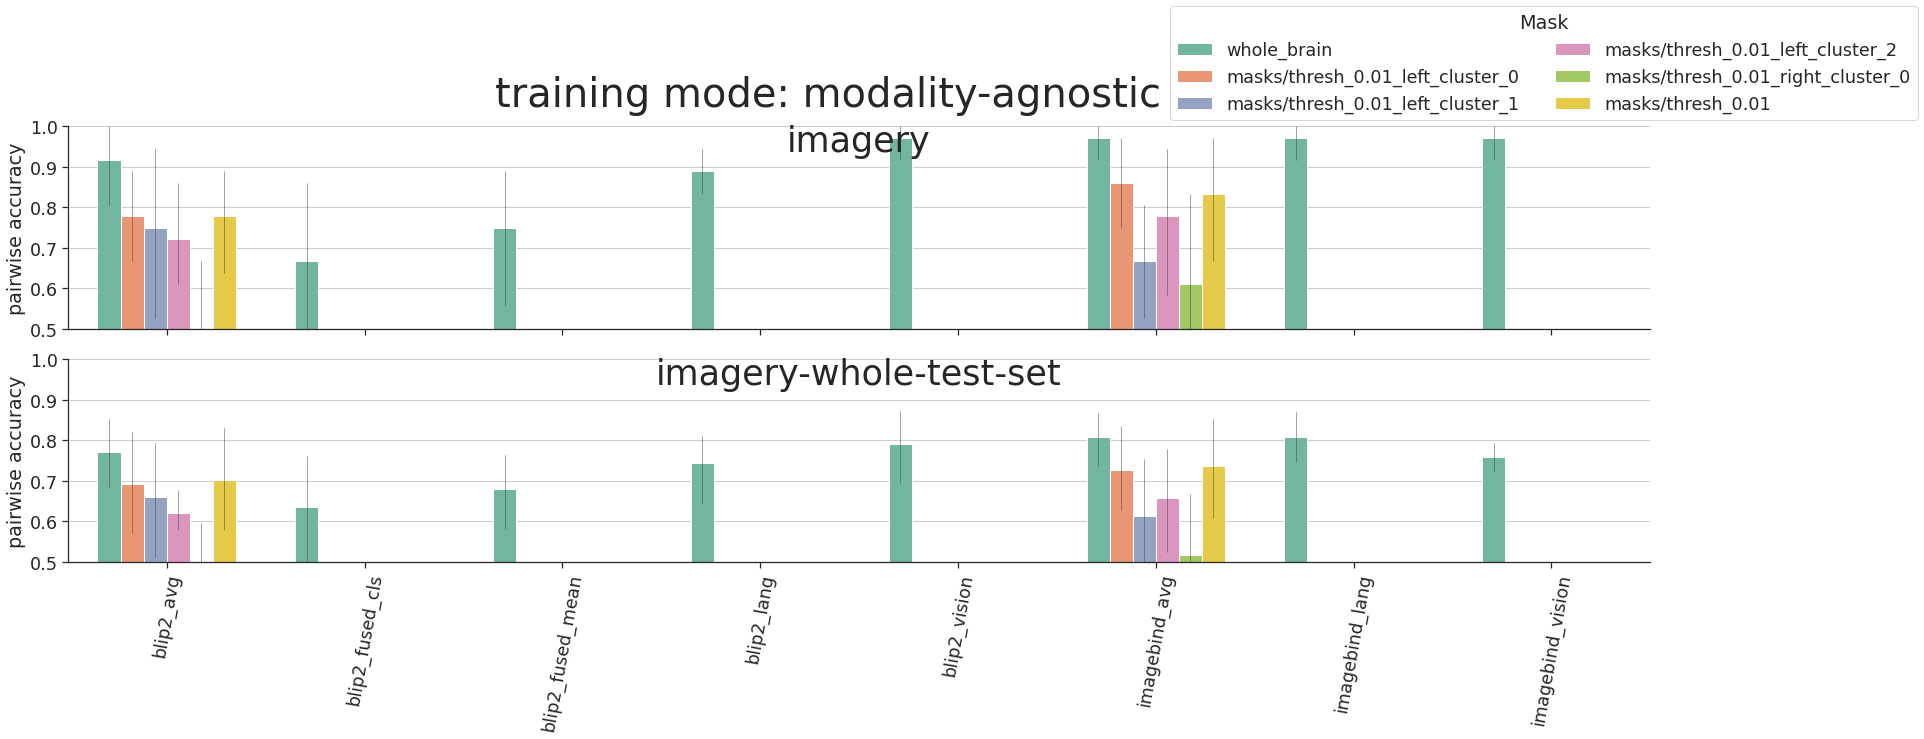

In [8]:
result = imagery_decoding_masks_plot("modality-agnostic")
# imagery_decoding_masks_plot("captions")
# imagery_decoding_masks_plot("images")

# result = result[result.model_feat == "blip2_avg"]
result = result[result.model_feat == "imagebind_avg"]

result[(result.metric == ACC_IMAGERY_WHOLE_TEST)].groupby(["model", "features", "mask", "subject"]).agg(mean_val=('value', 'mean'), count=('value', 'count')) # subject

Series([], Name: num_voxels, dtype: float64)


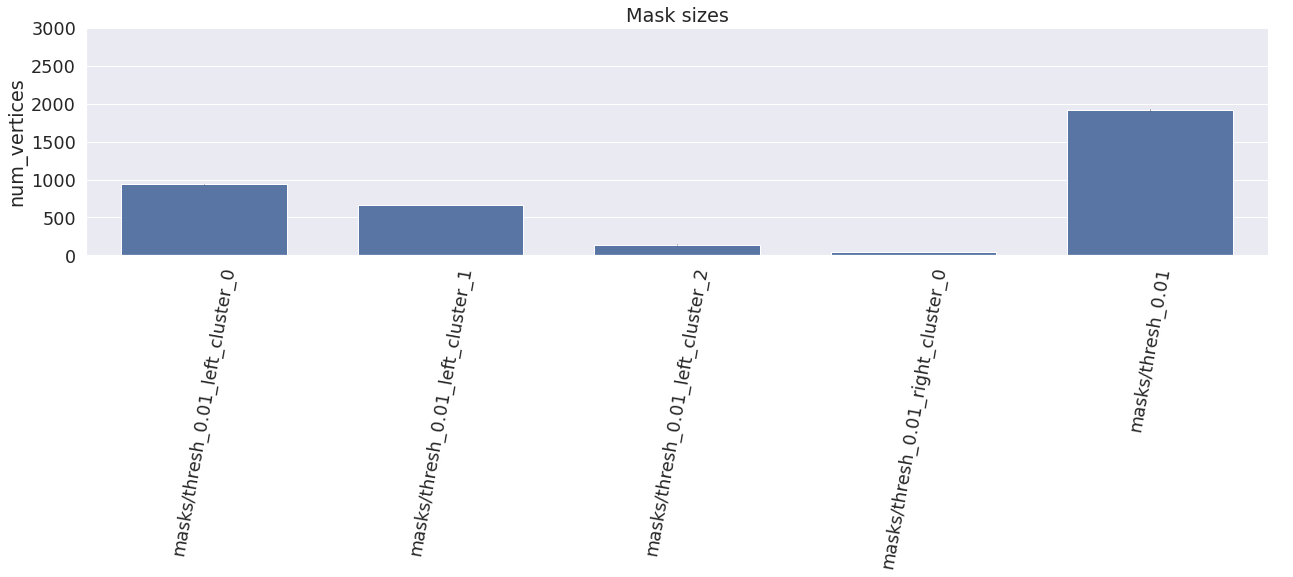

In [9]:
def create_mask_sizes_plot(data, x_variable, ylim=(0.5, 1), y_variable="value", ylabel="pairwise_acc", row_variable="metric", hue_variable="condition", title=None):
    sns.set(font_scale=1.6)
    TRAIN_MODE_ORDER = ["images", "captions", "modality-agnostic"]
    FEAT_ORDER = ["vision models", "language models", "multimodal models"]
    
    data_to_plot = data.copy()
    
    data_to_plot = data_to_plot[data_to_plot.training_mode == "modality-agnostic"]
    
    data_to_plot["features"] = data_to_plot.features.replace({"vision": "vision models", "lang": "language models", "matched": "multimodal models"})
        
    height = 4.5
    aspect = 4
   
    g = sns.catplot(data_to_plot, kind="bar", x=x_variable, y=y_variable, row=row_variable, row_order=None, col=None, height=height, aspect=aspect, hue=hue_variable, hue_order=None,
                    palette=None, err_kws={'linewidth': 0.5, 'alpha': 0.99}, width=0.7)

    g.set(ylim=ylim, ylabel=ylabel, xlabel='')
    g.tick_params(axis='x', rotation=80)
    if title:
        g.fig.suptitle(title, y=1.03)
    return data_to_plot
    
data_plotted = result[result["mask"] != "whole_brain"]
create_mask_sizes_plot(data_plotted, x_variable="mask", y_variable="num_voxels", ylim=(0, 3000), ylabel="num_vertices", row_variable=None, hue_variable=None)
_ = plt.title("Mask sizes")

print(data_plotted[(data_plotted.metric == "mean")].groupby(["mask"])['num_voxels'].mean())


# Nearest Neighbors of imagined pictures

In [10]:
MODEL = "imagebind"
df_model = data_default_feats[data_default_feats.model == MODEL]

train_latents = dict()
train_stim_ids = dict()
for subject in SUBJECTS:
    assert len(df_model.vision_features.unique()) == 1
    features = df_model.features.values[0]
    # print(features)
    vision_features = df_model.vision_features.values[0]
    # print(vision_features)
    lang_features = df_model.lang_features.values[0]
    # print(lang_features)
    _, stim_ids, stim_types = get_fmri_data_paths(subject, "train")
    train_stim_ids[subject] = stim_ids
    train_stim_types = ["image"] * len(train_stim_ids[subject])
    train_latents[subject], _ = get_nn_latent_data(
                                        MODEL, features,
                                        vision_features,
                                        lang_features,
                                        train_stim_ids[subject],
                                        stim_types,
                                        subject,
                                        "train"
                                    )

In [11]:
# all_scores = []

# df = data_default_feats.copy()
# df_model = df[df.model == MODEL]

# for subject in SUBJECTS:
#     df_subj = df_model[(df_model.training_mode == 'modality-agnostic') & (df_model.subject == subject)]
#     test_predictions = df_subj[df_subj.metric == "predictions"].value.item()
#     test_latents = df_subj[df_subj.metric == "latents"].value.item()
#     stimulus_ids = df_subj[df_subj.metric == "stimulus_ids"].value.item()
#     stimulus_types = df_subj[df_subj.metric == "stimulus_types"].value.item()

#     imagery_predictions = df_subj[df_subj.metric == "imagery_predictions"].value.item()
#     imagery_latents = df_subj[df_subj.metric == "imagery_latents"].value.item()

#     test_latents_image = test_latents[stimulus_types == IMAGE]
#     test_latents_caption = test_latents[stimulus_types == CAPTION]

#     candidate_set_latents = np.concatenate((imagery_latents, test_latents))
#     # candidate_set_latents = np.concatenate((imagery_latents, train_latents[subject]))

#     res = pairwise_accuracy(candidate_set_latents, imagery_predictions)
    
#     # print(res)
#     all_scores.append(res)
#         # all_scores.append(res[ACC_IMAGES])
#         # break
# print(np.mean(all_scores))



In [12]:
from utils import COCO_IMAGES_DIR, STIM_INFO_PATH, STIMULI_IDS_PATH
from feature_extraction.feat_extraction_utils import CoCoDataset
from PIL import Image

coco_ds = CoCoDataset(COCO_IMAGES_DIR, STIM_INFO_PATH, STIMULI_IDS_PATH, 'image')


In [13]:
MAX_HEIGHT = 500

def display_stimuli(coco_ids):
    print(coco_ids)
    imgs = [np.array(coco_ds.get_img_by_coco_id(img_id)) for img_id in coco_ids]
    # min_height = np.min([np.array(im).shape[0] for im in imgs])
    imgs = [np.vstack((img, np.repeat(255, max(0, MAX_HEIGHT - img.shape[0]) * img.shape[1]* img.shape[2]).reshape((max(0, MAX_HEIGHT - img.shape[0]), img.shape[1], img.shape[2])).astype(img.dtype)))[:MAX_HEIGHT,:,:] for img in imgs]
    stacked = np.hstack(imgs)
    img = Image.fromarray(stacked)
    display(img)

In [14]:
df = data_to_plot.copy()
df["mask"].unique()

array(['whole_brain'], dtype=object)

In [ ]:
%precision 3

MODEL = "imagebind"
features = "avg"
# features = "lang"

training_mode = 'modality-agnostic'
# training_mode = 'images'

resolution = "fsaverage7"
# mask = 'thresh_0.0001_left_cluster_0'
mask = 'whole_brain'


df = all_data.copy()

df = df[df.model == MODEL]
df = df[df.features == features]
df = df[df.training_mode == training_mode]

df = df[df['mask'] == mask]
if mask != "whole_brain":
    df = df[df.resolution == resolution]
    df = df[df.surface == True]


assert len(df[df.metric == "predictions"]) == len(SUBJECTS)
all_ranks = []
for subject in SUBJECTS:
    print(subject)
    df_subj = df[df.subject == subject]
    # print(df_subj)
    test_predictions = df_subj[df_subj.metric == "predictions"].value.item()
    test_latents = df_subj[df_subj.metric == "latents"].value.item()
    stimulus_ids = df_subj[df_subj.metric == "stimulus_ids"].value.item()
    stimulus_types = df_subj[df_subj.metric == "stimulus_types"].value.item()

    imagery_predictions = df_subj[df_subj.metric == "imagery_predictions"].value.item()
    imagery_latents = df_subj[df_subj.metric == "imagery_latents"].value.item()

    test_latents_image = test_latents[stimulus_types == IMAGE]
    test_latents_caption = test_latents[stimulus_types == CAPTION]

    candidate_set_latents = np.concatenate((imagery_latents, test_latents))
    # candidate_set_latents = np.concatenate((imagery_latents, test_latents_image))

    # candidate_set_latents = np.concatenate((imagery_latents, train_latents[subject]))
    imagery_stimulus_ids = np.array([i[1] for i in IMAGERY_SCENES[subject]])
    imagery_stimulus_captions = np.array([i[0] for i in IMAGERY_SCENES[subject]])

    candidate_set_latents_ids = np.concatenate((imagery_stimulus_ids, train_stim_ids[subject]))
   
    preds_normalize = Normalize(imagery_predictions.mean(axis=0), imagery_predictions.std(axis=0))
    imagery_predictions = preds_normalize(imagery_predictions)

    dist_mat = get_distance_matrix(imagery_predictions, candidate_set_latents) #, metric="euclidean"
    
    for imagery_stimulus_id, imagery_stimulus_caption, nneighbors_row in zip(imagery_stimulus_ids, imagery_stimulus_captions, dist_mat):
        print(f"imagery stimulus: {imagery_stimulus_caption}")
        # display(coco_ds.get_img_by_coco_id(imagery_stimulus_id))
        target_location = np.argwhere(candidate_set_latents_ids == imagery_stimulus_id)[0][0]
        nneighbors_ids = candidate_set_latents_ids[np.argsort(nneighbors_row)]
        rank = np.argwhere(nneighbors_ids == imagery_stimulus_id)[0][0]
        all_ranks.append(rank)
        display(f"distance to target: {nneighbors_row[target_location]:.3f} | rank: {rank} of {len(nneighbors_row)}")
        display(f"nearest neighbors distances: {np.sort(nneighbors_row)[:10]}")
        display_stimuli(nneighbors_ids[:10])
        print("\n")
    print("\n\n")

print(all_ranks)
print(np.mean(all_ranks))
print(np.mean(all_ranks)/len(nneighbors_row))

# 